# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   fortitude   1206 non-null   int64 
 1   cha         1206 non-null   int64 
 2   hp          1206 non-null   int64 
 3   ac          1206 non-null   int64 
 4   book        1206 non-null   object
 5   level       1206 non-null   int64 
 6   reflex      1206 non-null   int64 
 7   int         1206 non-null   int64 
 8   con         1206 non-null   int64 
 9   will        1206 non-null   int64 
 10  dex         1206 non-null   int64 
 11  focus       1206 non-null   int32 
 12  wis         1206 non-null   int64 
 13  str         1206 non-null   int64 
 14  perception  1206 non-null   int64 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [3]:
df.head()

,fortitude,cha,hp,ac,book,level,reflex,int,con,will,dex,focus,wis,str,perception
0,22,1,215,29,Pathfinder Bestiary,10,19,1,5,17,2,1,2,7,20
1,21,1,220,28,Pathfinder Bestiary,10,14,-4,5,16,0,0,2,9,16
2,20,-2,175,25,Pathfinder Bestiary,8,17,-4,6,15,3,0,3,7,17
3,30,6,315,41,Pathfinder Bestiary,17,29,6,5,32,4,1,5,7,30
4,6,1,20,16,Pathfinder Bestiary,1,10,-1,1,4,3,1,1,-5,6


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


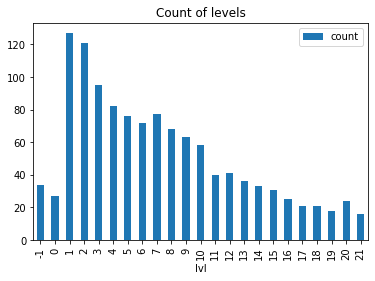

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.26
RMSE: 0.51
MAE: 0.36


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


In [17]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.30
RMSE: 0.55

Round type: 0.33
MSE: 0.29
RMSE: 0.54

Round type: 0.45
MSE: 0.29
RMSE: 0.54



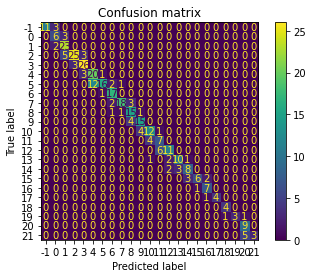

In [18]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [19]:
from training.results import assess_regression_model

In [20]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 21:51:20,842] A new study created in memory with name: no-name-0725cd11-bd84-4049-8b2f-1463dc894216
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.189409 + 0.0383375
[200]	cv_agg's l2: 0.186192 + 0.0363665
[300]	cv_agg's l2: 0.185649 + 0.0359677


feature_fraction, val_score: 0.185461:  14%|######4                                      | 1/7 [00:01<00:09,  1.60s/it]

Early stopping, best iteration is:
[260]	cv_agg's l2: 0.185461 + 0.0359196
[100]	cv_agg's l2: 0.179259 + 0.0419818
[200]	cv_agg's l2: 0.178337 + 0.0421037
[300]	cv_agg's l2: 0.177652 + 0.0403507


feature_fraction, val_score: 0.177386:  29%|############8                                | 2/7 [00:03<00:09,  1.90s/it]

Early stopping, best iteration is:
[282]	cv_agg's l2: 0.177386 + 0.0405247
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


feature_fraction, val_score: 0.157705:  43%|###################2                         | 3/7 [00:05<00:07,  1.78s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.168881 + 0.0320895
[200]	cv_agg's l2: 0.164195 + 0.0281335


feature_fraction, val_score: 0.157705:  57%|#########################7                   | 4/7 [00:06<00:04,  1.64s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.181203 + 0.0430548
[200]	cv_agg's l2: 0.177706 + 0.0402042


feature_fraction, val_score: 0.157705:  71%|################################1            | 5/7 [00:09<00:03,  1.98s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.181768 + 0.043427
[200]	cv_agg's l2: 0.179286 + 0.0409861


feature_fraction, val_score: 0.157705:  86%|######################################5      | 6/7 [00:12<00:02,  2.40s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.174038 + 0.0436248
[200]	cv_agg's l2: 0.171576 + 0.0406042


feature_fraction, val_score: 0.157705: 100%|#############################################| 7/7 [00:15<00:00,  2.16s/it]


Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783


num_leaves, val_score: 0.157705:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:   5%|##5                                               | 1/20 [00:02<00:44,  2.35s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  10%|#####                                             | 2/20 [00:04<00:43,  2.43s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  15%|#######5                                          | 3/20 [00:07<00:41,  2.46s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.163143 + 0.0206193
[200]	cv_agg's l2: 0.16006 + 0.019421


num_leaves, val_score: 0.157705:  20%|##########                                        | 4/20 [00:09<00:40,  2.51s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  25%|############5                                     | 5/20 [00:12<00:38,  2.60s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  30%|###############                                   | 6/20 [00:15<00:36,  2.59s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  35%|#################5                                | 7/20 [00:17<00:33,  2.55s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  40%|####################                              | 8/20 [00:19<00:29,  2.46s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  45%|######################5                           | 9/20 [00:22<00:26,  2.44s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  50%|########################5                        | 10/20 [00:24<00:24,  2.44s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  55%|##########################9                      | 11/20 [00:28<00:25,  2.86s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  60%|#############################4                   | 12/20 [00:31<00:22,  2.82s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.201234 + 0.022547


num_leaves, val_score: 0.157705:  60%|#############################4                   | 12/20 [00:32<00:22,  2.82s/it]

[200]	cv_agg's l2: 0.179851 + 0.0196647
Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783


num_leaves, val_score: 0.157705:  65%|###############################8                 | 13/20 [00:32<00:15,  2.19s/it]

[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  70%|##################################3              | 14/20 [00:34<00:13,  2.26s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  75%|####################################7            | 15/20 [00:36<00:11,  2.30s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  80%|#######################################2         | 16/20 [00:39<00:09,  2.36s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  85%|#########################################6       | 17/20 [00:41<00:07,  2.38s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  90%|############################################1    | 18/20 [00:44<00:04,  2.37s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705:  95%|##############################################5  | 19/20 [00:46<00:02,  2.35s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.16051 + 0.021731
[200]	cv_agg's l2: 0.158381 + 0.019451


num_leaves, val_score: 0.157705: 100%|#################################################| 20/20 [00:48<00:00,  2.45s/it]


Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783


bagging, val_score: 0.157705:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.165695 + 0.0264598
[200]	cv_agg's l2: 0.161519 + 0.0204206


bagging, val_score: 0.157705:  10%|#####3                                               | 1/10 [00:02<00:20,  2.24s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.237881 + 0.0295041
[200]	cv_agg's l2: 0.216259 + 0.0273084


bagging, val_score: 0.157705:  20%|##########6                                          | 2/10 [00:03<00:13,  1.69s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.162785 + 0.0215549
[200]	cv_agg's l2: 0.160313 + 0.0212381


bagging, val_score: 0.157705:  30%|###############9                                     | 3/10 [00:05<00:14,  2.02s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.18369 + 0.0149378
[200]	cv_agg's l2: 0.177177 + 0.0143085


bagging, val_score: 0.157705:  40%|#####################2                               | 4/10 [00:07<00:11,  1.87s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.18807 + 0.0280598
[200]	cv_agg's l2: 0.18194 + 0.0209182


bagging, val_score: 0.157705:  50%|##########################5                          | 5/10 [00:09<00:09,  1.86s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.223102 + 0.0349186
[200]	cv_agg's l2: 0.209785 + 0.0344487


bagging, val_score: 0.157705:  60%|###############################8                     | 6/10 [00:10<00:06,  1.69s/it]

Early stopping, best iteration is:
[150]	cv_agg's l2: 0.157705 + 0.019783
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


bagging, val_score: 0.156947:  70%|#####################################                | 7/10 [00:13<00:06,  2.10s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.162375 + 0.0226863
[200]	cv_agg's l2: 0.159695 + 0.0202617


bagging, val_score: 0.156947:  80%|##########################################4          | 8/10 [00:16<00:04,  2.32s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.171943 + 0.0259356
[200]	cv_agg's l2: 0.165842 + 0.0210057


bagging, val_score: 0.156947:  90%|###############################################7     | 9/10 [00:19<00:02,  2.38s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.16522 + 0.0235808
[200]	cv_agg's l2: 0.160992 + 0.0221582


bagging, val_score: 0.156947: 100%|####################################################| 10/10 [00:22<00:00,  2.20s/it]


Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823


feature_fraction_stage2, val_score: 0.156947:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


feature_fraction_stage2, val_score: 0.156947:  33%|############6                         | 1/3 [00:02<00:05,  2.84s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.171527 + 0.0279954
[200]	cv_agg's l2: 0.16837 + 0.0242488


feature_fraction_stage2, val_score: 0.156947:  67%|#########################3            | 2/3 [00:05<00:02,  2.85s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.171527 + 0.0279954
[200]	cv_agg's l2: 0.16837 + 0.0242488


feature_fraction_stage2, val_score: 0.156947: 100%|######################################| 3/3 [00:08<00:00,  2.90s/it]


Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823


regularization_factors, val_score: 0.156947:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.161674 + 0.0227722
[200]	cv_agg's l2: 0.158848 + 0.0206252


regularization_factors, val_score: 0.156947:   5%|#9                                    | 1/20 [00:02<00:53,  2.81s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.216993 + 0.0325571
[200]	cv_agg's l2: 0.20234 + 0.0311729


regularization_factors, val_score: 0.156947:  10%|###8                                  | 2/20 [00:03<00:32,  1.80s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  15%|#####7                                | 3/20 [00:06<00:38,  2.26s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  20%|#######6                              | 4/20 [00:09<00:40,  2.54s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  25%|#########5                            | 5/20 [00:12<00:40,  2.67s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  30%|###########4                          | 6/20 [00:15<00:37,  2.70s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  35%|#############3                        | 7/20 [00:18<00:35,  2.77s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  40%|###############2                      | 8/20 [00:21<00:33,  2.78s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  45%|#################1                    | 9/20 [00:23<00:30,  2.78s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  50%|##################5                  | 10/20 [00:26<00:27,  2.80s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  55%|####################3                | 11/20 [00:29<00:25,  2.81s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  60%|######################2              | 12/20 [00:32<00:22,  2.80s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  65%|########################             | 13/20 [00:35<00:19,  2.81s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  70%|#########################9           | 14/20 [00:38<00:16,  2.83s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  75%|###########################7         | 15/20 [00:40<00:14,  2.82s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  80%|#############################6       | 16/20 [00:43<00:11,  2.80s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  85%|###############################4     | 17/20 [00:46<00:08,  2.82s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  90%|#################################3   | 18/20 [00:49<00:05,  2.89s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947:  95%|###################################1 | 19/20 [00:52<00:02,  2.86s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.160122 + 0.0231327
[200]	cv_agg's l2: 0.157167 + 0.0197807


regularization_factors, val_score: 0.156947: 100%|#####################################| 20/20 [00:55<00:00,  2.75s/it]


Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823


min_data_in_leaf, val_score: 0.156947:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.176532 + 0.018187
[200]	cv_agg's l2: 0.171608 + 0.014238


min_data_in_leaf, val_score: 0.156947:  20%|#########                                    | 1/5 [00:02<00:09,  2.47s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.156947 + 0.0194823
[100]	cv_agg's l2: 0.156166 + 0.0295228
[200]	cv_agg's l2: 0.154153 + 0.0282995


min_data_in_leaf, val_score: 0.153685:  40%|##################                           | 2/5 [00:05<00:08,  2.92s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.153685 + 0.0282204
[100]	cv_agg's l2: 0.155341 + 0.0245704
[200]	cv_agg's l2: 0.154379 + 0.0245796


min_data_in_leaf, val_score: 0.153685:  60%|###########################                  | 3/5 [00:08<00:06,  3.05s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.153685 + 0.0282204
[100]	cv_agg's l2: 0.234527 + 0.0194571
[200]	cv_agg's l2: 0.219411 + 0.0225724


min_data_in_leaf, val_score: 0.153685:  80%|####################################         | 4/5 [00:10<00:02,  2.50s/it]

Early stopping, best iteration is:
[169]	cv_agg's l2: 0.153685 + 0.0282204
[100]	cv_agg's l2: 0.770158 + 0.105435


min_data_in_leaf, val_score: 0.153685:  80%|####################################         | 4/5 [00:11<00:02,  2.50s/it]

[200]	cv_agg's l2: 0.741837 + 0.112931
Early stopping, best iteration is:
[169]	cv_agg's l2: 0.153685 + 0.0282204


min_data_in_leaf, val_score: 0.153685: 100%|#############################################| 5/5 [00:11<00:00,  2.27s/it]


In [21]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.15368474761176734
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.2098659866946613e-08
    lambda_l2: 1.1719434158988724e-08
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.9815300589765639
    bagging_freq: 5
    min_child_samples: 10


In [22]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [23]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.46
MSE test: 0.21
MAE test: 0.34



In [24]:
results.loc[1] = [
    "chronological",
    "Optuna",
    len(X_test.columns),
    mse,
    rmse,
    mae,
]

In [25]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.21
RMSE: 0.46

Round type: round
MSE: 0.26
RMSE: 0.51

Round type: 0.33
MSE: 0.26
RMSE: 0.51

Round type: 0.45
MSE: 0.25
RMSE: 0.50



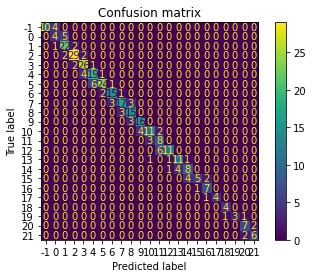

In [26]:
plot_confusion_matrix("round", predict, y_test)

## Random split

In [27]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.148111	valid_0's l1: 0.267273


In [28]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.15
RMSE: 0.38
MAE: 0.27


In [30]:
results.loc[3] = ["random", "normal", len(X_test.columns), mse, rmse, mae]

In [31]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.15
RMSE: 0.38

Round type: round
MSE: 0.15
RMSE: 0.39

Round type: 0.33
MSE: 0.21
RMSE: 0.45

Round type: 0.45
MSE: 0.17
RMSE: 0.41



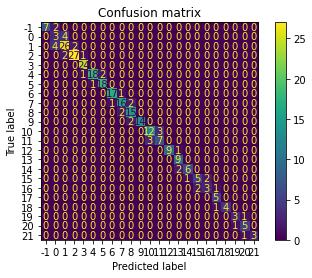

In [32]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [33]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-10-28 21:54:40,044] A new study created in memory with name: no-name-3a778def-1a88-461c-ba07-6cce3c0f6992
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.194332 + 0.0456681
[200]	cv_agg's l2: 0.191166 + 0.0440507


feature_fraction, val_score: 0.190737:  14%|######4                                      | 1/7 [00:02<00:17,  2.88s/it]

Early stopping, best iteration is:
[187]	cv_agg's l2: 0.190737 + 0.0445075
[100]	cv_agg's l2: 0.180712 + 0.0475642
[200]	cv_agg's l2: 0.17974 + 0.0465825


feature_fraction, val_score: 0.178886:  29%|############8                                | 2/7 [00:05<00:13,  2.79s/it]

Early stopping, best iteration is:
[178]	cv_agg's l2: 0.178886 + 0.0463005
[100]	cv_agg's l2: 0.173175 + 0.0522516
[200]	cv_agg's l2: 0.171655 + 0.0504929
[300]	cv_agg's l2: 0.172123 + 0.0491355


feature_fraction, val_score: 0.171187:  43%|###################2                         | 3/7 [00:08<00:11,  2.96s/it]

Early stopping, best iteration is:
[232]	cv_agg's l2: 0.171187 + 0.050085
[100]	cv_agg's l2: 0.194343 + 0.0511619
[200]	cv_agg's l2: 0.193353 + 0.0488543
[300]	cv_agg's l2: 0.194374 + 0.0480618


feature_fraction, val_score: 0.171187:  57%|#########################7                   | 4/7 [00:12<00:09,  3.08s/it]

Early stopping, best iteration is:
[232]	cv_agg's l2: 0.171187 + 0.050085
[100]	cv_agg's l2: 0.189453 + 0.0508321
[200]	cv_agg's l2: 0.186991 + 0.0496918
[300]	cv_agg's l2: 0.187711 + 0.0481169


feature_fraction, val_score: 0.171187:  71%|################################1            | 5/7 [00:15<00:06,  3.16s/it]

Early stopping, best iteration is:
[232]	cv_agg's l2: 0.171187 + 0.050085
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978


feature_fraction, val_score: 0.167739:  86%|######################################5      | 6/7 [00:17<00:02,  2.97s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.167739 + 0.0251302
[100]	cv_agg's l2: 0.190408 + 0.0527822
[200]	cv_agg's l2: 0.187438 + 0.0475067


feature_fraction, val_score: 0.167739: 100%|#############################################| 7/7 [00:20<00:00,  2.96s/it]


Early stopping, best iteration is:
[180]	cv_agg's l2: 0.167739 + 0.0251302


num_leaves, val_score: 0.167739:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978


num_leaves, val_score: 0.167739:   5%|##5                                               | 1/20 [00:02<00:49,  2.61s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.167739 + 0.0251302
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978


num_leaves, val_score: 0.167739:  10%|#####                                             | 2/20 [00:05<00:48,  2.68s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.167739 + 0.0251302
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978


num_leaves, val_score: 0.167739:  15%|#######5                                          | 3/20 [00:08<00:45,  2.70s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.167739 + 0.0251302
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978


num_leaves, val_score: 0.167739:  20%|##########                                        | 4/20 [00:10<00:43,  2.71s/it]

Early stopping, best iteration is:
[180]	cv_agg's l2: 0.167739 + 0.0251302
[100]	cv_agg's l2: 0.183793 + 0.0226573
[200]	cv_agg's l2: 0.171326 + 0.0187655
[300]	cv_agg's l2: 0.165509 + 0.0177282
[400]	cv_agg's l2: 0.164159 + 0.0157736
[500]	cv_agg's l2: 0.16334 + 0.0160419


num_leaves, val_score: 0.163113:  25%|############5                                     | 5/20 [00:12<00:35,  2.35s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.167906 + 0.0272876
[200]	cv_agg's l2: 0.166975 + 0.0252723
[300]	cv_agg's l2: 0.167588 + 0.02579
[400]	cv_agg's l2: 0.169315 + 0.0264457
[500]	cv_agg's l2: 0.169417 + 0.0262351


num_leaves, val_score: 0.163113:  30%|###############                                   | 6/20 [00:16<00:41,  2.94s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.338019 + 0.062473
[200]	cv_agg's l2: 0.294726 + 0.0456479
[300]	cv_agg's l2: 0.280008 + 0.0411838
[400]	cv_agg's l2: 0.270613 + 0.0394649
[500]	cv_agg's l2: 0.263424 + 0.038211


num_leaves, val_score: 0.163113:  35%|#################5                                | 7/20 [00:17<00:29,  2.27s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  40%|####################                              | 8/20 [00:23<00:40,  3.35s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  45%|######################5                           | 9/20 [00:28<00:45,  4.09s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  50%|########################5                        | 10/20 [00:34<00:46,  4.63s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  55%|##########################9                      | 11/20 [00:40<00:44,  4.92s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  60%|#############################4                   | 12/20 [00:46<00:41,  5.18s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  65%|###############################8                 | 13/20 [00:51<00:37,  5.36s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  70%|##################################3              | 14/20 [00:57<00:32,  5.41s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  75%|####################################7            | 15/20 [01:03<00:27,  5.49s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  80%|#######################################2         | 16/20 [01:08<00:22,  5.58s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  85%|#########################################6       | 17/20 [01:14<00:16,  5.64s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113:  90%|############################################1    | 18/20 [01:20<00:11,  5.77s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.167085 + 0.0254162
[200]	cv_agg's l2: 0.165698 + 0.0244262
[300]	cv_agg's l2: 0.166934 + 0.0245064
[400]	cv_agg's l2: 0.168141 + 0.024932
[500]	cv_agg's l2: 0.168617 + 0.0248239


num_leaves, val_score: 0.163113:  95%|##############################################5  | 19/20 [01:26<00:05,  5.67s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.169171 + 0.0258974
[200]	cv_agg's l2: 0.167933 + 0.0248978
[300]	cv_agg's l2: 0.16966 + 0.0249438
[400]	cv_agg's l2: 0.170316 + 0.0249747
[500]	cv_agg's l2: 0.171043 + 0.0249063


num_leaves, val_score: 0.163113: 100%|#################################################| 20/20 [01:31<00:00,  4.60s/it]


Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105


bagging, val_score: 0.163113:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.203871 + 0.0333669
[200]	cv_agg's l2: 0.188307 + 0.0295965
[300]	cv_agg's l2: 0.185147 + 0.0289285
[400]	cv_agg's l2: 0.182805 + 0.029248
[500]	cv_agg's l2: 0.18077 + 0.0250332


bagging, val_score: 0.163113:  10%|#####3                                               | 1/10 [00:01<00:16,  1.89s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.182366 + 0.0278635
[200]	cv_agg's l2: 0.171121 + 0.022599
[300]	cv_agg's l2: 0.167003 + 0.0192932
[400]	cv_agg's l2: 0.165564 + 0.0199251
[500]	cv_agg's l2: 0.164684 + 0.0190568


bagging, val_score: 0.163113:  20%|##########6                                          | 2/10 [00:03<00:15,  2.00s/it]

Early stopping, best iteration is:
[491]	cv_agg's l2: 0.163113 + 0.0157105
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147967
[500]	cv_agg's l2: 0.161299 + 0.0144827


bagging, val_score: 0.160683:  30%|###############9                                     | 3/10 [00:05<00:13,  1.86s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.187603 + 0.025558
[200]	cv_agg's l2: 0.17456 + 0.0207546
[300]	cv_agg's l2: 0.171598 + 0.0192222
[400]	cv_agg's l2: 0.169267 + 0.0185359
[500]	cv_agg's l2: 0.16808 + 0.0178607


bagging, val_score: 0.160683:  40%|#####################2                               | 4/10 [00:07<00:11,  1.89s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147967
[500]	cv_agg's l2: 0.161299 + 0.0144827


bagging, val_score: 0.160683:  50%|##########################5                          | 5/10 [00:09<00:09,  1.82s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.188023 + 0.0289944
[200]	cv_agg's l2: 0.173567 + 0.0233653
[300]	cv_agg's l2: 0.168703 + 0.02088
[400]	cv_agg's l2: 0.16749 + 0.0188883
[500]	cv_agg's l2: 0.166122 + 0.0174749


bagging, val_score: 0.160683:  60%|###############################8                     | 6/10 [00:11<00:07,  1.78s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.187301 + 0.0266325
[200]	cv_agg's l2: 0.172465 + 0.0214027
[300]	cv_agg's l2: 0.168599 + 0.019255
[400]	cv_agg's l2: 0.167274 + 0.0177831
[500]	cv_agg's l2: 0.165925 + 0.0181527


bagging, val_score: 0.160683:  70%|#####################################                | 7/10 [00:12<00:05,  1.78s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.186172 + 0.0266599
[200]	cv_agg's l2: 0.175013 + 0.0231165
[300]	cv_agg's l2: 0.17046 + 0.0220108
[400]	cv_agg's l2: 0.170551 + 0.0207921
[500]	cv_agg's l2: 0.170666 + 0.0207337


bagging, val_score: 0.160683:  80%|##########################################4          | 8/10 [00:14<00:03,  1.83s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.197407 + 0.0224898
[200]	cv_agg's l2: 0.183287 + 0.0215398
[300]	cv_agg's l2: 0.17906 + 0.0188569
[400]	cv_agg's l2: 0.177086 + 0.0189261
[500]	cv_agg's l2: 0.175065 + 0.0173207


bagging, val_score: 0.160683:  90%|###############################################7     | 9/10 [00:16<00:01,  1.85s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.195609 + 0.0230206
[200]	cv_agg's l2: 0.182303 + 0.0233778
[300]	cv_agg's l2: 0.179001 + 0.0239262
[400]	cv_agg's l2: 0.178397 + 0.023391
[500]	cv_agg's l2: 0.17871 + 0.0236417


bagging, val_score: 0.160683: 100%|####################################################| 10/10 [00:18<00:00,  1.87s/it]


Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017


feature_fraction_stage2, val_score: 0.160683:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.187756 + 0.0341577
[200]	cv_agg's l2: 0.176404 + 0.029958
[300]	cv_agg's l2: 0.170859 + 0.0281373
[400]	cv_agg's l2: 0.168921 + 0.0261184
[500]	cv_agg's l2: 0.167192 + 0.0261993


feature_fraction_stage2, val_score: 0.160683:  33%|############6                         | 1/3 [00:01<00:03,  1.88s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.187756 + 0.0341577
[200]	cv_agg's l2: 0.176404 + 0.029958
[300]	cv_agg's l2: 0.170859 + 0.0281373
[400]	cv_agg's l2: 0.168921 + 0.0261184
[500]	cv_agg's l2: 0.167192 + 0.0261993


feature_fraction_stage2, val_score: 0.160683:  67%|#########################3            | 2/3 [00:03<00:01,  1.80s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147967
[500]	cv_agg's l2: 0.161299 + 0.0144827


feature_fraction_stage2, val_score: 0.160683: 100%|######################################| 3/3 [00:05<00:00,  1.83s/it]


Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017


regularization_factors, val_score: 0.160683:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.186483 + 0.0292307
[200]	cv_agg's l2: 0.172774 + 0.0286092
[300]	cv_agg's l2: 0.167636 + 0.0275078
[400]	cv_agg's l2: 0.16604 + 0.0265407
[500]	cv_agg's l2: 0.165634 + 0.0263272


regularization_factors, val_score: 0.160683:   5%|#9                                    | 1/20 [00:01<00:32,  1.71s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147967
[500]	cv_agg's l2: 0.161299 + 0.0144827


regularization_factors, val_score: 0.160683:  10%|###8                                  | 2/20 [00:03<00:31,  1.74s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147967
[500]	cv_agg's l2: 0.161299 + 0.0144827


regularization_factors, val_score: 0.160683:  15%|#####7                                | 3/20 [00:05<00:30,  1.77s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147967
[500]	cv_agg's l2: 0.161299 + 0.0144827


regularization_factors, val_score: 0.160683:  20%|#######6                              | 4/20 [00:07<00:28,  1.75s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147967
[500]	cv_agg's l2: 0.161299 + 0.0144827


regularization_factors, val_score: 0.160683:  25%|#########5                            | 5/20 [00:08<00:26,  1.74s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147967
[500]	cv_agg's l2: 0.161299 + 0.0144827


regularization_factors, val_score: 0.160683:  30%|###########4                          | 6/20 [00:10<00:24,  1.77s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146017
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147968
[500]	cv_agg's l2: 0.161299 + 0.0144828


regularization_factors, val_score: 0.160683:  35%|#############3                        | 7/20 [00:12<00:22,  1.76s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147968
[500]	cv_agg's l2: 0.161299 + 0.0144827


regularization_factors, val_score: 0.160683:  40%|###############2                      | 8/20 [00:14<00:21,  1.75s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147968
[500]	cv_agg's l2: 0.161299 + 0.0144828


regularization_factors, val_score: 0.160683:  45%|#################1                    | 9/20 [00:15<00:19,  1.74s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147968
[500]	cv_agg's l2: 0.161299 + 0.0144827


regularization_factors, val_score: 0.160683:  50%|##################5                  | 10/20 [00:18<00:19,  1.97s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147968
[500]	cv_agg's l2: 0.161299 + 0.0144828


regularization_factors, val_score: 0.160683:  55%|####################3                | 11/20 [00:20<00:19,  2.15s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147968
[500]	cv_agg's l2: 0.161299 + 0.0144828


regularization_factors, val_score: 0.160683:  60%|######################2              | 12/20 [00:22<00:17,  2.13s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147968
[500]	cv_agg's l2: 0.161299 + 0.0144828


regularization_factors, val_score: 0.160683:  65%|########################             | 13/20 [00:24<00:14,  2.08s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240895
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.016309
[400]	cv_agg's l2: 0.162644 + 0.0147968
[500]	cv_agg's l2: 0.161299 + 0.0144828


regularization_factors, val_score: 0.160683:  70%|#########################9           | 14/20 [00:26<00:11,  1.98s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240895
[200]	cv_agg's l2: 0.169846 + 0.0189572
[300]	cv_agg's l2: 0.164566 + 0.016309
[400]	cv_agg's l2: 0.162644 + 0.0147968
[500]	cv_agg's l2: 0.161299 + 0.0144828


regularization_factors, val_score: 0.160683:  75%|###########################7         | 15/20 [00:28<00:09,  1.89s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240897
[200]	cv_agg's l2: 0.170052 + 0.0188277
[300]	cv_agg's l2: 0.164877 + 0.0162387
[400]	cv_agg's l2: 0.162993 + 0.0149159
[500]	cv_agg's l2: 0.16256 + 0.0139953


regularization_factors, val_score: 0.160683:  80%|#############################6       | 16/20 [00:30<00:07,  1.88s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240896
[200]	cv_agg's l2: 0.170052 + 0.0188276
[300]	cv_agg's l2: 0.164877 + 0.0162386
[400]	cv_agg's l2: 0.162993 + 0.0149158
[500]	cv_agg's l2: 0.16256 + 0.0139952


regularization_factors, val_score: 0.160683:  85%|###############################4     | 17/20 [00:31<00:05,  1.82s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240896
[200]	cv_agg's l2: 0.170036 + 0.0188405
[300]	cv_agg's l2: 0.164858 + 0.0162551
[400]	cv_agg's l2: 0.162785 + 0.0151173
[500]	cv_agg's l2: 0.161948 + 0.0145753


regularization_factors, val_score: 0.160683:  90%|#################################3   | 18/20 [00:33<00:03,  1.80s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183 + 0.0240894
[200]	cv_agg's l2: 0.169846 + 0.0189571
[300]	cv_agg's l2: 0.164566 + 0.0163089
[400]	cv_agg's l2: 0.162644 + 0.0147968
[500]	cv_agg's l2: 0.161299 + 0.0144828


regularization_factors, val_score: 0.160683:  95%|###################################1 | 19/20 [00:35<00:01,  1.77s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.183002 + 0.0240909
[200]	cv_agg's l2: 0.170053 + 0.018829
[300]	cv_agg's l2: 0.164833 + 0.0162603
[400]	cv_agg's l2: 0.162485 + 0.0147812
[500]	cv_agg's l2: 0.161375 + 0.0148046


regularization_factors, val_score: 0.160683: 100%|#####################################| 20/20 [00:36<00:00,  1.85s/it]


Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018


min_data_in_leaf, val_score: 0.160683:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.194553 + 0.0233723
[200]	cv_agg's l2: 0.184638 + 0.0187601
[300]	cv_agg's l2: 0.178942 + 0.0181556
[400]	cv_agg's l2: 0.176189 + 0.0171045
[500]	cv_agg's l2: 0.174951 + 0.0175055


min_data_in_leaf, val_score: 0.160683:  20%|#########                                    | 1/5 [00:01<00:06,  1.67s/it]

Early stopping, best iteration is:
[483]	cv_agg's l2: 0.160683 + 0.0146018
[100]	cv_agg's l2: 0.176108 + 0.0222876
[200]	cv_agg's l2: 0.160922 + 0.0205709
[300]	cv_agg's l2: 0.15541 + 0.0194982
[400]	cv_agg's l2: 0.153493 + 0.0168074
[500]	cv_agg's l2: 0.152518 + 0.0153044


min_data_in_leaf, val_score: 0.152025:  20%|#########                                    | 1/5 [00:03<00:06,  1.67s/it]

[600]	cv_agg's l2: 0.152449 + 0.0157179
Early stopping, best iteration is:
[569]	cv_agg's l2: 0.152025 + 0.0155369


min_data_in_leaf, val_score: 0.152025:  40%|##################                           | 2/5 [00:03<00:05,  1.85s/it]

[100]	cv_agg's l2: 0.687853 + 0.0581723
[200]	cv_agg's l2: 0.645544 + 0.0576653
[300]	cv_agg's l2: 0.627321 + 0.0657924
[400]	cv_agg's l2: 0.612965 + 0.0698756
[500]	cv_agg's l2: 0.60545 + 0.0727112


min_data_in_leaf, val_score: 0.152025:  40%|##################                           | 2/5 [00:05<00:05,  1.85s/it]

[600]	cv_agg's l2: 0.597419 + 0.073684
Early stopping, best iteration is:
[569]	cv_agg's l2: 0.152025 + 0.0155369


min_data_in_leaf, val_score: 0.152025:  60%|###########################                  | 3/5 [00:05<00:03,  1.84s/it]

[100]	cv_agg's l2: 0.175472 + 0.0244107
[200]	cv_agg's l2: 0.163535 + 0.0232698
[300]	cv_agg's l2: 0.157249 + 0.0217102
[400]	cv_agg's l2: 0.152624 + 0.0184441
[500]	cv_agg's l2: 0.150745 + 0.0176332
[600]	cv_agg's l2: 0.150128 + 0.0167689
[700]	cv_agg's l2: 0.149527 + 0.0163615


min_data_in_leaf, val_score: 0.149434:  80%|####################################         | 4/5 [00:08<00:02,  2.28s/it]

[800]	cv_agg's l2: 0.149811 + 0.0162836
Early stopping, best iteration is:
[710]	cv_agg's l2: 0.149434 + 0.0162368
[100]	cv_agg's l2: 0.251874 + 0.0264593
[200]	cv_agg's l2: 0.236628 + 0.0202567
[300]	cv_agg's l2: 0.229941 + 0.0192379
[400]	cv_agg's l2: 0.225103 + 0.019667
[500]	cv_agg's l2: 0.221458 + 0.0191389
[600]	cv_agg's l2: 0.218763 + 0.0197895
[700]	cv_agg's l2: 0.217657 + 0.0208367


min_data_in_leaf, val_score: 0.149434: 100%|#############################################| 5/5 [00:10<00:00,  2.00s/it]

[800]	cv_agg's l2: 0.216742 + 0.021411
Early stopping, best iteration is:
[710]	cv_agg's l2: 0.149434 + 0.0162368


In [34]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14943387515558357
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 5.916766022467656e-05
    lambda_l2: 1.670479576125135e-05
    num_leaves: 6
    feature_fraction: 0.4
    bagging_fraction: 0.9975477621074372
    bagging_freq: 1
    min_child_samples: 10


In [35]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [36]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.35
MSE test: 0.12
MAE test: 0.24



In [37]:
results.loc[4] = ["random", "Optuna", len(X_test.columns), mse, rmse, mae]

In [38]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.04
RMSE: 0.20

Round type: round
MSE: 0.04
RMSE: 0.20

Round type: 0.33
MSE: 0.05
RMSE: 0.23

Round type: 0.45
MSE: 0.04
RMSE: 0.19



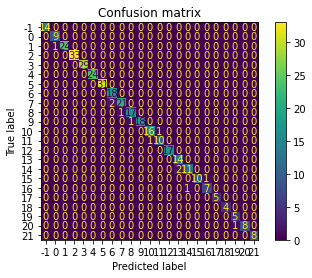

In [39]:
plot_confusion_matrix("round", predict, y_test)

## Summary

In [40]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE,MAE
0,chronological,normal,13,0.260866,0.510751,0.357177
1,chronological,Optuna,13,0.213902,0.462495,0.337589
3,random,normal,13,0.148111,0.384853,0.267273
4,random,Optuna,13,0.123021,0.350743,0.242031


In [41]:
from training.results import plot_summary

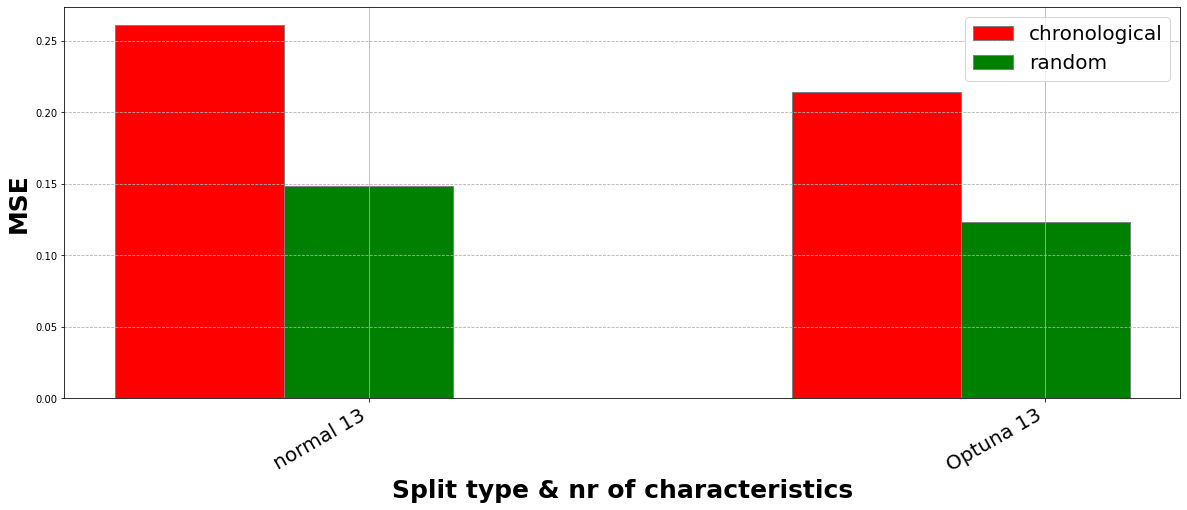

In [42]:
plot_summary(results, "MSE")

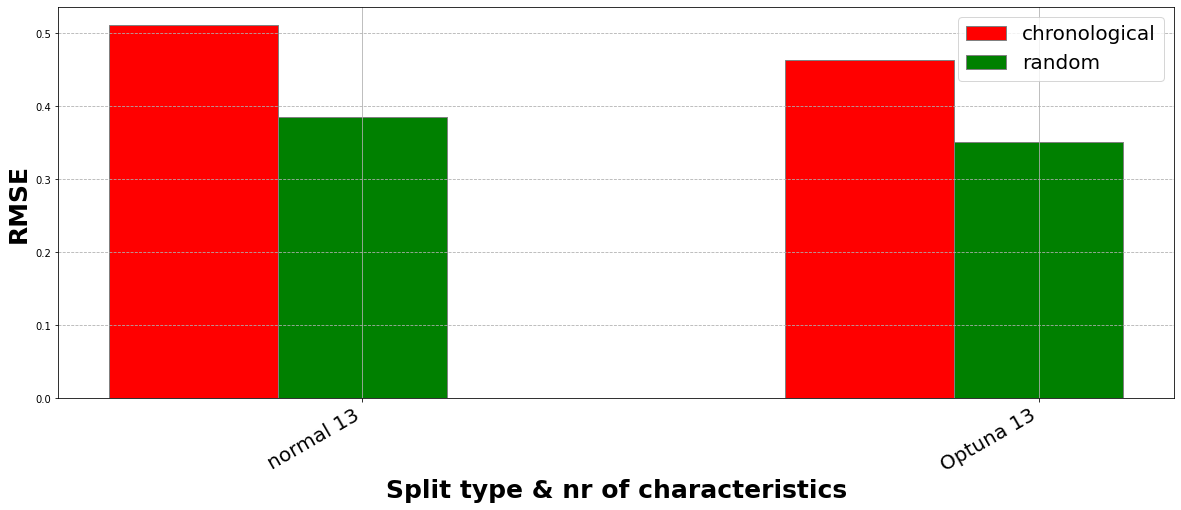

In [43]:
plot_summary(results, "RMSE")

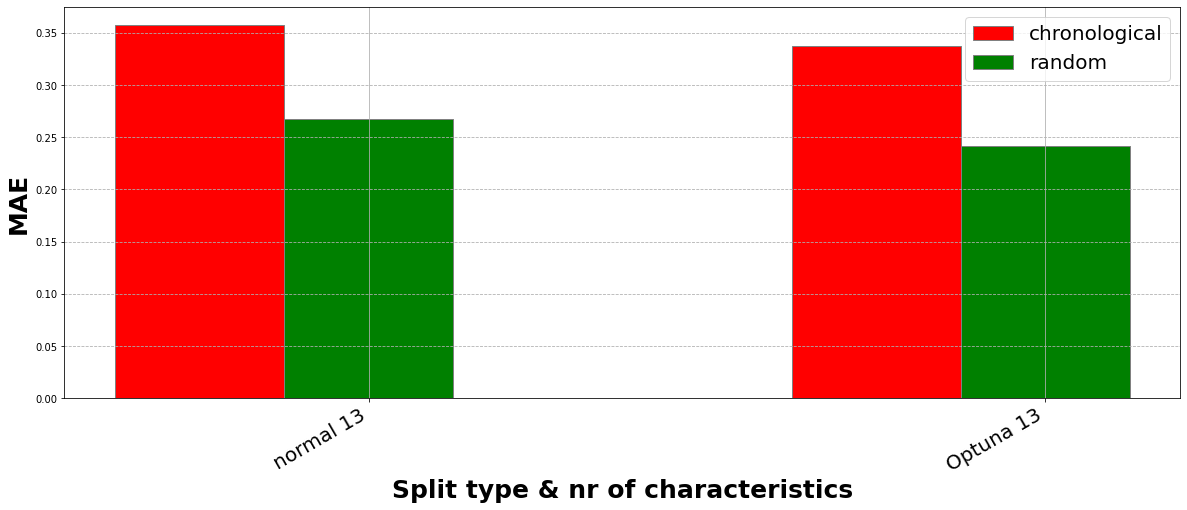

In [44]:
plot_summary(results, "MAE")

In [45]:
results.to_json("./lightgbm_second_results.json")